In [1]:
import sys
sys.path.append("../../")
import warnings
import numpy as np
import astropy.units as u
from astropy.constants import h, e, m_e, c, sigma_T
from agnpy.synchrotron import R, epsilon_equivalency
from agnpy.compton import compton_kernel
from agnpy.emission_regions import Blob
from agnpy.targets import PointSourceBehindJet
import matplotlib.pyplot as plt

e = e.gauss

## my implementation of the trapezoidal rule in log-log space

In [2]:
def log(x):
    # smallest positive float (before 0)
    float_tiny = np.finfo(np.float64).tiny
    # largest positive float
    float_max = np.finfo(np.float64).max
    values = np.clip(x, float_tiny, float_max)
    return np.log(values)

In [3]:
def trapz_loglog(y, x, axis=0):
    """
    Integrate along the given axis using the composite trapezoidal rule in
    loglog space.

    Integrate `y` (`x`) along given axis in loglog space.

    Parameters
    ----------
    y : array_like
        Input array to integrate.
    x : array_like, optional
        Independent variable to integrate over.
    axis : int, optional
        Specify the axis.

    Returns
    -------
    trapz : float
        Definite integral as approximated by trapezoidal rule in loglog space.
    """
    try:
        y_unit = y.unit
        y = y.value
    except AttributeError:
        y_unit = 1.0
    try:
        x_unit = x.unit
        x = x.value
    except AttributeError:
        x_unit = 1.0
    
    slice_low = [slice(None)] * y.ndim
    slice_up = [slice(None)] * y.ndim
    # multi-dimensional equivalent of x_low = x[:-1]
    slice_low[axis] = slice(None, -1)
    # multi-dimensional equivalent of x_up = x[1:]
    slice_up[axis] = slice(1, None)

    slice_low = tuple(slice_low)
    slice_up = tuple(slice_up)

    # reshape x to be broadcasted with y
    if x.ndim == 1:
        shape = [1] * y.ndim
        shape[axis] = x.shape[0]
        x = x.reshape(shape)
        
    x_low = x[slice_low] 
    x_up = x[slice_up]
    y_low = y[slice_low]
    y_up = y[slice_up]
    
    log_x_low = log(x_low)
    log_x_up = log(x_up)
    log_y_low = log(y_low)
    log_y_up = log(y_up)
    
    # index in the bin
    m = (log_y_low - log_y_up) / (log_x_low - log_x_up)
    vals = y_low / (m + 1) * (x_up * (x_up / x_low) ** m - x_low)
    
    # value of y very close to zero will make m large and explode the exponential
    tozero = (
        np.isclose(y_low, 0, atol=0, rtol=1e-10) +
        np.isclose(y_up, 0, atol=0, rtol=1e-10) +
        np.isclose(x_low, x_up, atol=0, rtol=1e-10)
    )
    vals[tozero] = 0.0
    
    return np.add.reduce(vals, axis) * x_unit * y_unit

## a simple test with a straight line in log-log scale

In [4]:
def line_loglog(x, m, n):
    """a straight line in loglog-space"""
    return x ** m * np.e ** n


def integral_line_loglog(x_min, x_max, m, n):
    """analytical integral of the line in log-log space"""
    f_low = line_loglog(x_min, m + 1, n) / (m + 1)
    f_up = line_loglog(x_max, m + 1, n) / (m + 1)
    return f_up - f_low

In [5]:
m = 1.5
n = -2.0
x = np.logspace(2, 5)
y = line_loglog(x, m, n)
y = np.asarray([y, y])

In [6]:
trapz_loglog(y.T, x, axis=0)

array([1.71187092e+11, 1.71187092e+11])

In [7]:
integral_line_loglog(x[0], x[-1], m, n)

171187091711.2689

In [8]:
np.trapz(y.T, x, axis=0)

array([1.71398971e+11, 1.71398971e+11])

In [9]:
1 - trapz_loglog(y.T, x, axis=0) / integral_line_loglog(x[0], x[-1], m, n)

array([2.22044605e-16, 2.22044605e-16])

In [10]:
1 - np.trapz(y.T, x, axis=0) / integral_line_loglog(x[0], x[-1], m, n)

array([-0.00123771, -0.00123771])

## a test with synchrotron radiation

In [11]:
blob = Blob()
nu = np.logspace(9, 20, 20) * u.Hz

# check the blob
print(blob)

* spherical emission region
 - R_b (radius of the blob): 1.00e+16 cm
 - V_b (volume of the blob): 4.19e+48 cm3
 - z (source redshift): 0.10
 - d_L (source luminosity distance):1.47e+27 cm
 - delta_D (blob Doppler factor): 1.00e+01
 - Gamma (blob Lorentz factor): 1.00e+01
 - Beta (blob relativistic velocity): 9.95e-01
 - theta_s (jet viewing angle): 5.74e+00 deg
 - B (magnetic field tangled to the jet): 1.00e+00 G
* electron spectrum
 - power law
 - k_e: 5.18e-11 1 / cm3
 - p: 2.30
 - gamma_min: 1.00e+02
 - gamma_max: 1.00e+06



In [12]:
def sed_synch(nu, integration):
    """compute the synchrotron SED"""
    epsilon = nu.to("", equivalencies=epsilon_equivalency)
    # correct epsilon to the jet comoving frame
    epsilon_prime = (1 + blob.z) * epsilon / blob.delta_D
    # electrond distribution lorentz factor
    gamma = blob.gamma
    N_e = blob.N_e(gamma)
    prefactor = np.sqrt(3) * epsilon * np.power(e, 3) * blob.B_cgs / h
    # for multidimensional integration
    # axis 0: electrons gamma
    # axis 1: photons epsilon
    # arrays starting with _ are multidimensional and used for integration
    _gamma = np.reshape(gamma, (gamma.size, 1))
    _N_e = np.reshape(N_e, (N_e.size, 1))
    _epsilon = np.reshape(epsilon, (1, epsilon.size))
    x_num = 4 * np.pi * _epsilon * np.power(m_e, 2) * np.power(c, 3)
    x_denom = 3 * e * blob.B_cgs * h * np.power(_gamma, 2)
    x = (x_num / x_denom).to_value("")
    integrand = _N_e * R(x)
    integral = integration(integrand, gamma, axis=0)
    emissivity = (prefactor * integral).to("erg s-1")
    sed_conversion = np.power(blob.delta_D, 4) / (
        4 * np.pi * np.power(blob.d_L, 2)
    )
    return (sed_conversion * emissivity).to("erg cm-2 s-1")

In [13]:
%%timeit
sed_synch(nu, np.trapz)

4.71 ms ± 118 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
%%timeit
sed_synch(nu, trapz_loglog)

5.47 ms ± 321 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


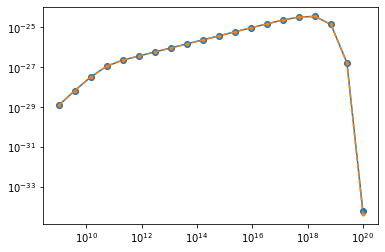

In [15]:
sed_trapz = sed_synch(nu, np.trapz)
sed_trapz_loglog = sed_synch(nu, trapz_loglog)
plt.loglog(nu, sed_trapz, marker="o")
plt.loglog(nu, sed_trapz_loglog, ls="--", marker=".")
plt.show()

## a test with inverse Compton radiation

In [16]:
def sed_flux_point_source(nu, target, r, integrate):
    """SED flux for EC on a point like source behind the jet

    Parameters
    ----------
    nu : `~astropy.units.Quantity`
        array of frequencies, in Hz, to compute the sed, **note** these are 
        observed frequencies (observer frame).
    """
    # define the dimensionless energy
    epsilon_s = nu.to("", equivalencies=epsilon_equivalency)
    # transform to BH frame
    epsilon_s *= 1 + blob.z
    # for multidimensional integration
    # axis 0: gamma
    # axis 1: epsilon_s
    # arrays starting with _ are multidimensional and used for integration
    gamma = blob.gamma_to_integrate
    transformed_N_e = blob.N_e(gamma / blob.delta_D).value
    _gamma = np.reshape(gamma, (gamma.size, 1))
    _N_e = np.reshape(transformed_N_e, (transformed_N_e.size, 1))
    _epsilon_s = np.reshape(epsilon_s, (1, epsilon_s.size))
    # define integrating function
    # notice once the value of mu = 1, phi can assume any value, we put 0
    # convenience
    _kernel = compton_kernel(
        _gamma, _epsilon_s, target.epsilon_0, blob.mu_s, 1, 0
    )
    _integrand = np.power(_gamma, -2) * _N_e * _kernel
    integral_gamma = integrate(_integrand, gamma, axis=0)
    prefactor_num = (
        3
        * sigma_T
        * target.L_0
        * np.power(epsilon_s, 2)
        * np.power(blob.delta_D, 3)
    )
    prefactor_denom = (
        np.power(2, 7)
        * np.power(np.pi, 2)
        * np.power(blob.d_L, 2)
        * np.power(r, 2)
        * np.power(target.epsilon_0, 2)
    )
    sed = prefactor_num / prefactor_denom * integral_gamma
    return sed.to("erg cm-2 s-1")

In [17]:
# target and distance
r = 1e16 * u.cm 
L_0 = 2e46 * u.Unit("erg s-1")
epsilon_0 = 1e-3
ps = PointSourceBehindJet(L_0, epsilon_0)

nu = np.logspace(20, 30) * u.Hz

# increase the size of the gamma grid
blob.set_gamma_size(500)

In [18]:
%%timeit
sed_flux_point_source(nu, ps, r, np.trapz)

5.04 ms ± 257 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
%%timeit
sed_flux_point_source(nu, ps, r, trapz_loglog)

/home/cosimo/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: overflow encountered in power
/home/cosimo/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply


7.9 ms ± 621 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


/home/cosimo/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: overflow encountered in power
/home/cosimo/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply


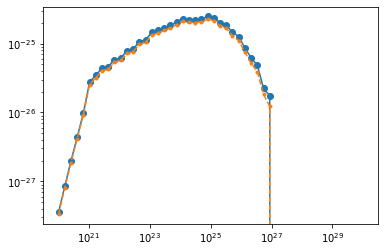

In [20]:
sed_trapz = sed_flux_point_source(nu, ps, r, np.trapz)
sed_trapz_loglog = sed_flux_point_source(nu, ps, r, trapz_loglog)
plt.loglog(nu, sed_trapz, marker="o")
plt.loglog(nu, sed_trapz_loglog, ls="--", marker=".")
plt.show()

In [21]:
print(sed_trapz_loglog)

[3.34697113e-28 8.04678250e-28 1.87175327e-27 4.18659898e-27
 9.33108317e-27 2.54254949e-26 3.19553026e-26 4.02814263e-26
 4.25844170e-26 5.37017564e-26 5.69385606e-26 7.19204962e-26
 7.65060919e-26 9.70125389e-26 1.03642311e-25 1.32531157e-25
 1.42614855e-25 1.54646069e-25 1.69209068e-25 1.87321386e-25
 2.10908609e-25 2.03269810e-25 2.01825405e-25 2.07617608e-25
 2.24984874e-25 2.15965611e-25 1.82545790e-25 1.66077770e-25
 1.30564626e-25 1.10019434e-25 7.46943212e-26 5.23814361e-26
 3.86681462e-26 1.83307582e-26 1.22368922e-26 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00] erg / (cm2 s)
